In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy

In [2]:
def E1(x):
    return scipy.special.expn(1, x)

def E2(x):
    return scipy.special.expn(2, x)

def E3(x):
    return scipy.special.expn(3, x)

In [4]:
def x(j, x_0, n, L):
    h_u = L/n
    if (j == 0):
        return x_0
    elif (j == n):
        return L
    else:
        return x_0 + j*h_u - h_u/2

In [5]:
def createA(L, n):
    h_u = L/n
    A = np.zeros((n, n))
    A[0, 0] = 1/2
    A[-1, -1] = 1/2
    for i in range(1, len(A)-1):
        A[i, i] = 1
    A = h_u*A
    return A

In [6]:
def createe(n, varTh, x_0, L):
    e = np.zeros(n)
    for i in range(1, len(e)+2):
        e[i-2] = (-1/varTh)*(E3(varTh*x(i, x_0, n, L)) - E3(varTh*x(i-1, x_0, n, L)))
    return e

In [8]:
def createE(L, n, varTh):
    h_u = L/n
    E = np.zeros((n,n))
    for i in range(1, n+2):
        for j in range(1, n+2):
            if (i > j) and (j == 2):
                E[i-2, j-2] = (1/(varTh**2))*(-E3(varTh*h_u*(i-1)) + E3(varTh*h_u*(i-2)) + E3(varTh*h_u*(i-1/2)) - E3(varTh*h_u*(i-3/2)))

            elif (i < j) and (j == n+1):
                E[i-2, j-2] = (1/(varTh**2))*(-E3(varTh*(L + h_u*(1/2-i))) + E3(varTh*(L + h_u*(3/2-i))) + E3(varTh*(L-i*h_u)) - E3(varTh*(L-h_u*(i-1))))

            elif (i < j) and (j != 2) and (j != n+1):
                E[i-2, j-2] = (1/(varTh**2))*(E3(varTh*h_u*(j-i+1)) + E3(varTh*h_u*(j-i-1)) - 2*E3(varTh*h_u*(j-i)))

            elif (i > j) and (j != 2) and (j != n+1):
                E[i-2, j-2] = (1/(varTh**2))*(E3(varTh*h_u*(i-j-1)) + E3(varTh*h_u*(i-j+1)) - 2*E3(varTh*h_u*(i-j)))

            elif (i == j) and (j != 2) and (j != n+1):
                E[i-2, j-2] = h_u*2/varTh + 2*(1/(varTh**2))*E3(varTh*h_u) - (1/(varTh**2))

    E[0, 0] = h_u/varTh + 2*(1/(varTh**2))*E3(varTh*h_u/2) - (1/(varTh**2))
    E[-1, -1] = h_u/varTh + 2*(1/(varTh**2))*E3(varTh*h_u/2) - (1/(varTh**2))

    return E

In [9]:
def createK(L, n, varTh):
    h_u = L/n
    K = np.zeros((n, n))
    for i in range(1, n+2):
        for j in range(1, n+2):
            if (i < j):
                K[i-2, j-2] = (1/(varTh**2))*(E3(varTh*h_u*(j-i+1)) + E3(varTh*h_u*(j-i-1)) - 2*E3(varTh*h_u*(j-i)))

            elif (i == j):
                K[i-2, j-2] = h_u*2/varTh + 2*(1/(varTh**2))*E3(varTh*h_u) - (1/(varTh**2))

            elif (i > j):
                K[i-2, j-2] = (1/(varTh**2))*(E3(varTh*h_u*(i-j-1)) + E3(varTh*h_u*(i-j+1)) - 2*E3(varTh*h_u*(i-j)))

    K = 1/2*K

    return K

In [10]:
def createB(n, A, E, s):
    B = np.zeros((n, n))
    B = A - (s/2)*E
    return B

In [11]:
def createC1(B, e, I_0):
    c1 = scipy.linalg.solve(B, 1/2*e)
    c1 = c1*I_0
    return c1

In [12]:
def createS(n, K, B):
    S = np.zeros((n, n))
    for i in range(len(K)):
        c = scipy.linalg.solve(B, K[:, i])
        S[:, i] = c
    return S

In [14]:
def createJack(L, n, kappa, s_0, S, lam, u):
    h_u = L/n
    nablaF = np.zeros((n, n))

#заполнение всей матрицы
    for j in range(len(nablaF)):
        for l in range(len(nablaF[j])):
            nablaF[j, l] = -4*kappa*kappa*s_0*S[j, l]*np.abs((u[l]))**3

#меняю диагональ
    for j in range(len(nablaF)):
        nablaF[j, j] = 2*lam/(h_u**2) + 4*kappa*(s_0 - kappa*s_0*S[j, j])*np.abs((u[j]))**3

#меняю первую поддиагональ
    for j in range(len(nablaF)):
        nablaF[j, j-1] = -lam/(h_u**2) - 4*kappa*kappa*s_0*S[j, j-1]*np.abs((u[j-1]))**3

#меняю первую наддиагональ
    for j in range(len(nablaF)-1):
        nablaF[j, j+1] = -lam/(h_u**2) - 4*kappa*kappa*s_0*S[j, j+1]*np.abs((u[j+1]))**3

#изменение первой строки
    for j in range(len(nablaF)):
        nablaF[0, j] = -2*kappa*kappa*s_0*S[0, j]*np.abs((u[j]))**3
    nablaF[0, 0] = lam/(h_u**2) + 2*kappa*(s_0 - kappa*s_0*S[0, 0])*np.abs((u[0]))**3
    nablaF[0, 1] = -lam/(h_u**2) - 2*kappa*kappa*s_0*S[0, 1]*np.abs((u[1]))**3

#изменение последней строки
    for j in range(len(nablaF)):
        nablaF[-1, j] = -2*kappa*kappa*s_0*S[-1, j]*np.abs((u[j]))**3
    nablaF[-1, -2] = -lam/(h_u**2) - 2*kappa*kappa*s_0*S[-1, -2]*np.abs((u[-2]))**3
    nablaF[-1, -1] = lam/(h_u**2) + 2*kappa*(s_0 - kappa*s_0*S[-1, -1])*np.abs((u[-1]))**3

    return nablaF

In [16]:
def sumOfRow(j, L, n, kappa, lam, s_0, S, u, c1):
    h_u = L/n
    z = np.zeros(n)
    if (j == 0):
        for i in range(len(z)):
            z[i] = 1/2*(-kappa*kappa*s_0*S[0, i]*(u[i])**4)
        z[0] = lam/(h_u**2)*u[0] + (1/2)*kappa*s_0*(u[0])**4 - (1/2)*kappa*kappa*s_0*S[0, 0]*(u[0])**4
        z[1] = -lam/(h_u**2)*u[1] - (1/2)*kappa*kappa*s_0*S[0, 1]*(u[1])**4
    elif (j == n-1):
        for i in range(len(z)):
            z[i] = 1/2*(-kappa*kappa*s_0*S[-1, i]*(u[i])**4)
        z[-2] = -lam/(h_u**2)*u[-2] - (1/2)*kappa*kappa*s_0*S[-1, -2]*(u[-2])**4
        z[-1] = lam/(h_u**2)*u[-1] + (1/2)*kappa*s_0*(u[-1])**4 - (1/2)*kappa*kappa*s_0*S[-1, -1]*(u[-1])**4
    else:
        for i in range(len(z)):
            z[i] = -kappa*kappa*s_0*S[j, i]*(u[i])**4
        z[j] = 2*lam/(h_u**2)*u[j] + kappa*s_0*(u[j])**4 - kappa*kappa*s_0*S[j, j]*(u[j])**4
        z[j+1] = -lam/(h_u**2)*u[j+1] - kappa*kappa*s_0*S[j, j+1]*(u[j+1])**4
        z[j-1] = -lam/(h_u**2)*u[j-1] - kappa*kappa*s_0*S[j, j-1]*(u[j-1])**4

    if (j == 0):
        q = sum(z) - (1/2)*kappa*c1[0]

    if (j == n-1):
        q = sum(z) - (1/2)*kappa*c1[-1]

    else:
        q = sum(z) - kappa*c1[j]

    return q

In [17]:
def createF(L, n, kappa, lam, s_0, S, u, c1):
    F = np.zeros(n)
    for j in range(len(F)):
        F[j] = sumOfRow(j, L, n, kappa, lam, s_0, S, u, c1)
    return F

In [18]:
def grid(L, n):
    h_u = L/n
    a_u = np.zeros(n+1)
    for i in range(len(a_u)):
        a_u[i] = a_u[i] + i*h_u
    return a_u

In [19]:
def sumI(j, n, kappa, s_0, S, u, c1):
    z = np.zeros(n)
    for i in range(len(z)):
        z[i] = kappa*s_0*S[j, i]*(u[i])**4
    return sum(z) + c1[j]

In [24]:
def createI(n, kappa, s_0, S, u, c1):
    I = np.zeros(n)
    for i in range(len(I)):
        I[i] = sumI(i, n, kappa, s_0, S, u, c1)
    return I


n = 1000
s_0 = scipy.constants.sigma
u1 = 280*np.ones(n)
x_0 = 0

336.3591644257147
17.616756310223046
0.05093463018502631
4.120462083655746e-07
1.815299577018151e-08
8.349327861414112e-09


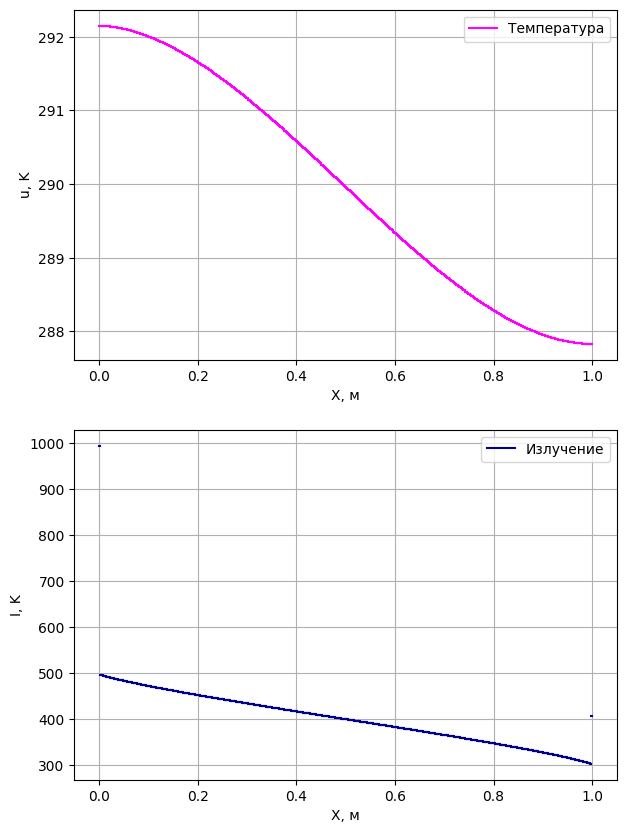

In [24]:
A = createA(L, n)
e = createe(n, varTh, x_0, L)
E = createE(L, n, varTh)
K = createK(L, n, varTh)
B = createB(n, A, E, s)
c1 = createC1(B, e, I_0)
S = createS(n, K, B)

eps = 10**(-8)
while True:
    nablaF = createJack(L, n, kappa, s_0, S, lam, u1)
    F = createF(L, n, kappa, lam, s_0, S, u1, c1)

    delta_u = scipy.linalg.solve(nablaF, -F)

    print(np.linalg.norm(delta_u, 2))

    u1 = u1 + delta_u

    if (np.linalg.norm(delta_u, 2) < eps):
        break

a = grid(L, n)
I1 = createI(n, kappa, s_0, S, u1, c1)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X, м')
axs[0].set_ylabel('u, K')

axs[1].set_xlabel('X, м')
axs[1].set_ylabel('I, K')

axs[0].plot([], [], color='fuchsia', label='Температура')
axs[1].plot([], [], color='darkblue', label='Излучение')

for i in range(len(u1)):
    axs[0].plot([a[i], a[i+1]], [u1[i], u1[i]], color = 'fuchsia')
    axs[1].plot([a[i], a[i+1]], [I1[i], I1[i]], color = 'darkblue')
axs[0].legend()
axs[1].legend()

plt.show()

In [22]:
def solver(L, n, kappa, s_0, s, lam, I_0):
    varTh = kappa + s
    u = np.ones(n)
    u = 280*u
    A = createA(L, n)
    e = createe(n, varTh, x_0, L)
    E = createE(L, n, varTh)
    K = createK(L, n, varTh)
    B = createB(n, A, E, s)
    c1 = createC1(B, e, I_0)
    S = createS(n, K, B)
    eps = 10**(-6)
    while True:
          nablaF = createJack(L, n, kappa, s_0, S, lam, u)
          F = createF(L, n, kappa, lam, s_0, S, u, c1)

          delta_u = scipy.linalg.solve(nablaF, -F)

          print(np.linalg.norm(delta_u, 2))

          u = u + delta_u

          if (np.linalg.norm(delta_u, 2) < eps):
              break
    I = createI(n, kappa, s_0, S, u1, c1)

    return u, I


def graph(L, u1, u2, u3, u4, u5, u6, I1, I2, I3, I4, I5, I6, k):
     a = grid(L, n)

     fig, axs = plt.subplots(2, 1, figsize = (7, 10))
     axs[0].grid(True)
     axs[1].grid(True)
     axs[0].set_xlabel('X')
     axs[0].set_ylabel('u')

     axs[1].set_xlabel('X')
     axs[1].set_ylabel('I')
     col = ['purple', 'cyan', 'fuchsia', 'blue', 'red', 'coral']

     if k == 1:
         for i in range(2):
             axs[i].plot([], [], color=col[0], label = '\u03F0=10, s=0.25')
             axs[i].plot([], [], color=col[1], label = '\u03F0=30, s=0.25')
             axs[i].plot([], [], color=col[2], label = '\u03F0=50, s=0.25')
             axs[i].plot([], [], color=col[3], label = '\u03F0=70, s=0.25')
             axs[i].plot([], [], color=col[4], label = '\u03F0=80, s=0.25')
             axs[i].plot([], [], color=col[5], label = '\u03F0=100, s=0.25')
     if k == 2:
         for i in range(2):
             axs[i].plot([], [], color=col[0], label = '\u03F0=0.3, s=10')
             axs[i].plot([], [], color=col[1], label = '\u03F0=0.3, s=30')
             axs[i].plot([], [], color=col[2], label = '\u03F0=0.3, s=50')
             axs[i].plot([], [], color=col[3], label = '\u03F0=0.3, s=70')
             axs[i].plot([], [], color=col[4], label = '\u03F0=0.3, s=80')
             axs[i].plot([], [], color=col[5], label = '\u03F0=0.3, s=100')

     if k == 3:
         for i in range(2):
             axs[i].plot([], [], color=col[0], label = 'I_0 = 500')
             axs[i].plot([], [], color=col[1], label = 'I_0 = 600')
             axs[i].plot([], [], color=col[2], label = 'I_0 = 700')
             axs[i].plot([], [], color=col[3], label = 'I_0 = 800')
             axs[i].plot([], [], color=col[4], label = 'I_0 = 900')
             axs[i].plot([], [], color=col[5], label = 'I_0 = 1000')

     if k == 4:
         for i in range(2):
             axs[i].plot([], [], color=col[0], label = '\u03bb = 10')
             axs[i].plot([], [], color=col[1], label = '\u03bb = 30')
             axs[i].plot([], [], color=col[2], label = '\u03bb = 50')
             axs[i].plot([], [], color=col[3], label = '\u03bb = 70')
             axs[i].plot([], [], color=col[4], label = '\u03bb = 80')
             axs[i].plot([], [], color=col[5], label = '\u03bb = 100')

     if k == 5:
         for i in range(2):
             axs[i].plot([], [], color=col[0], label = '\u03bb = 0')
             axs[i].plot([], [], color=col[1], label = '\u03bb = 0.1')
             axs[i].plot([], [], color=col[2], label = '\u03bb = 0.05')
             axs[i].plot([], [], color=col[3], label = '\u03bb = 0.01')
             axs[i].plot([], [], color=col[4], label = '\u03bb = 0.005')
             axs[i].plot([], [], color=col[5], label = '\u03bb = 0.001')

      
         

     for i in range(1, len(u1)):
        axs[0].plot([a[i], a[i+1]], [u1[i], u1[i]], color = col[0])
        axs[0].plot([a[i], a[i+1]], [u2[i], u2[i]], color = col[1])
        axs[0].plot([a[i], a[i+1]], [u3[i], u3[i]], color = col[2])
        axs[0].plot([a[i], a[i+1]], [u4[i], u4[i]], color = col[3])
        axs[0].plot([a[i], a[i+1]], [u5[i], u5[i]], color = col[4])
        axs[0].plot([a[i], a[i+1]], [u6[i], u6[i]], color = col[5])

     for i in range(1, len(u1)-2):
        axs[1].plot([a[i], a[i+1]], [I1[i], I1[i]], color = col[0])
        axs[1].plot([a[i], a[i+1]], [I2[i], I2[i]], color = col[1])
        axs[1].plot([a[i], a[i+1]], [I3[i], I3[i]], color = col[2])
        axs[1].plot([a[i], a[i+1]], [I4[i], I4[i]], color = col[3])
        axs[1].plot([a[i], a[i+1]], [I5[i], I5[i]], color = col[4])
        axs[1].plot([a[i], a[i+1]], [I6[i], I6[i]], color = col[5])
     axs[0].legend()
     axs[1].legend()

     plt.show()


In [25]:
unew, Inew = solver(1, 1000, 0.3, s_0, 0.25, 0.6, 800)

347.7414661371
18.955420255490843
0.05920457970848572
6.136696713893958e-07


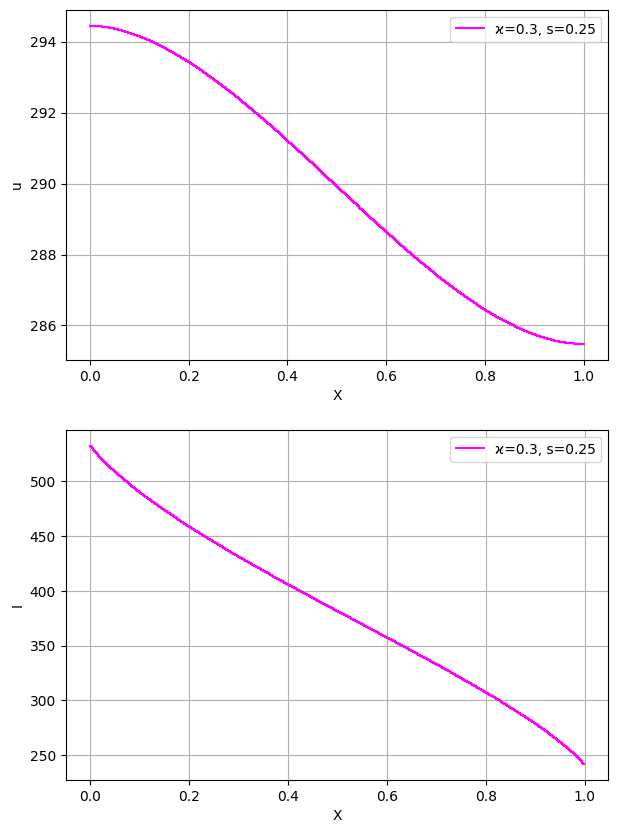

In [26]:
a = grid(1, n)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X')
axs[0].set_ylabel('u')

axs[1].set_xlabel('X')
axs[1].set_ylabel('I')
col = ['purple', 'cyan', 'fuchsia', 'blue', 'red', 'coral']
for i in range(2):
    axs[i].plot([], [], color=col[2], label = '\u03F0=0.3, s=0.25')
for i in range(1, len(u1)):
    axs[0].plot([a[i], a[i+1]], [unew[i], unew[i]], color = col[2])
for i in range(1, len(u1)-2):
    axs[1].plot([a[i], a[i+1]], [Inew[i], Inew[i]], color = col[2])
axs[0].legend()
axs[1].legend()

plt.show()


In [52]:
u1, I1 = solver(1, 1000, 0.2, s_0, 0.15, 0.6, 800)
u2, I2 = solver(1, 1000, 0.56, s_0, 0.15, 0.6, 800)
u3, I3 = solver(1, 1000, 0.92, s_0, 0.15, 0.6, 800)
u4, I4 = solver(1, 1000, 1.28, s_0, 0.15, 0.6, 800)
u5, I5 = solver(1, 1000, 1.64, s_0, 0.15, 0.6, 800)
u6, I6 = solver(1, 1000, 2, s_0, 0.15, 0.6, 800)

337.7977912886877
17.780090687070395
0.051903110671815
4.4850866274194634e-07
375.140735662534
22.59961722583249
0.08562481478966778
1.1802514629686244e-06
1.501489015030137e-08
426.3875141564923
30.482846892495107
0.1617942212366228
4.383914371830566e-06
6.539104097873474e-09
476.0277448956828
39.322584889422046
0.27853571500108926
1.3421360814917472e-05
2.2120658770567435e-08
519.6851006108642
48.18314144591672
0.42947788076010945
3.250449295790246e-05
3.809590847697152e-08
557.0071982165344
56.73146387257259
0.6079341423258295
6.614087904522154e-05
2.6403934851225616e-09


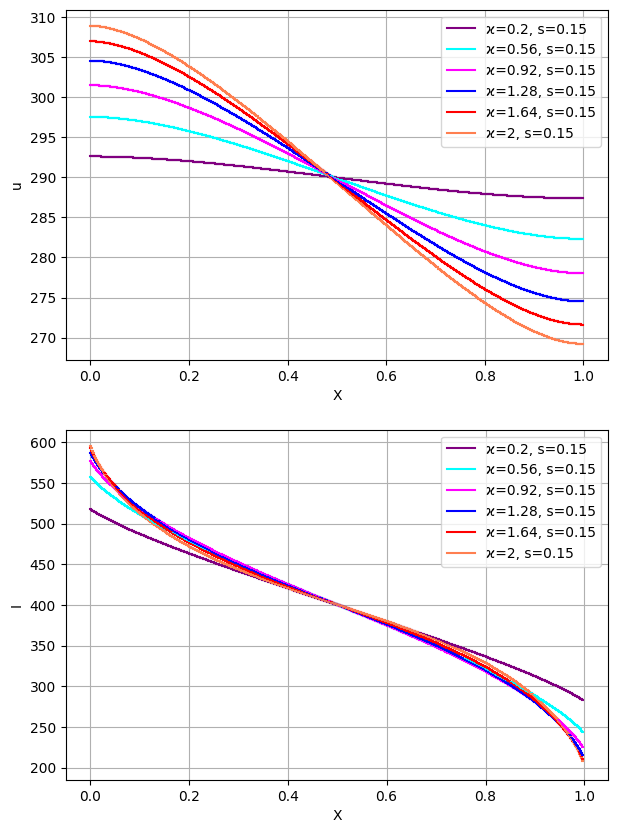

In [60]:
graph(1, u1, u2, u3, u4, u5, u6, I1, I2, I3, I4, I5, I6, 1)

In [61]:
u7, I7 = solver(1, 1000, 0.3, s_0, 0.1, 0.6, 800)
u8, I8 = solver(1, 1000, 0.3, s_0, 1.08, 0.6, 800)
u9, I9 = solver(1, 1000, 0.3, s_0, 2.06, 0.6, 800)
u10, I10 = solver(1, 1000, 0.3, s_0, 3.04, 0.6, 800)
u11, I11 = solver(1, 1000, 0.3, s_0, 4.02, 0.6, 800)
u12, I12 = solver(1, 1000, 0.3, s_0, 5, 0.6, 800)

343.95035987979395
18.503462717202584
0.056342989483242914
5.240184343512967e-07
363.14038246486126
20.86850268462697
0.07212429534851465
8.616751695256435e-07
373.39485331878643
22.250558404994457
0.08229723029294243
1.0568001059302311e-06
1.1851654174301424e-08
379.11315439072376
23.10672025925478
0.088981821729627
1.3211132829486143e-06
4.792418100288978e-09
382.2563974270988
23.65316116485298
0.09342642437799913
1.4995455671594843e-06
1.1729419278171526e-08
383.7986729234243
24.000854874282343
0.09635046611758263
1.5306143311958897e-06
5.505170149677206e-09


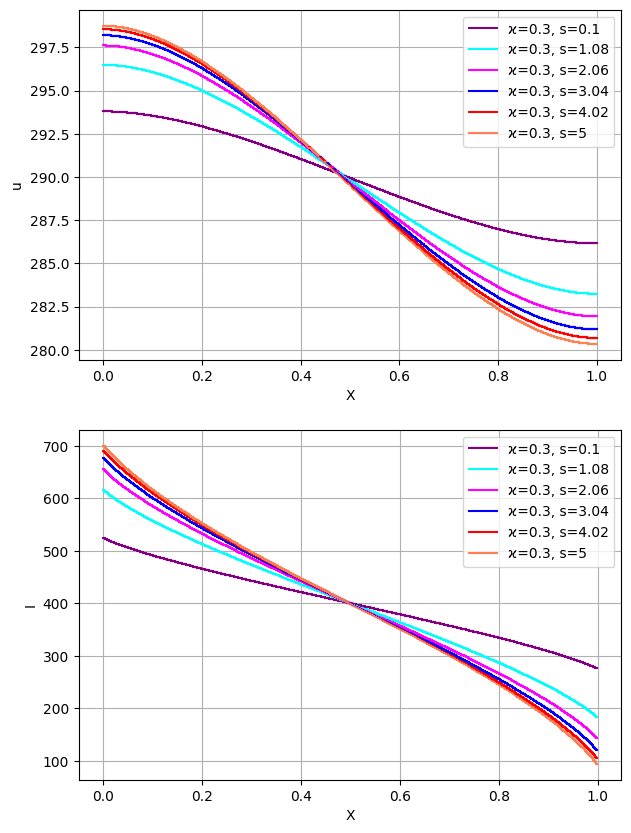

In [62]:
graph(1, u7, u8, u9, u10, u11, u12, I7, I8, I9, I10, I11, I12, 2)

In [64]:
u13, I13 = solver(4, 1000, 0.2, s_0, 0.15, 0.6, 650)
u14, I14 = solver(4, 1000, 0.56, s_0, 0.15, 0.6, 650)
u15, I15 = solver(4, 1000, 0.92, s_0, 0.15, 0.6, 650)
u16, I16 = solver(4, 1000, 1.28, s_0, 0.15, 0.6, 650)
u17, I17 = solver(4, 1000, 1.64, s_0, 0.15, 0.6, 650)
u18, I18 = solver(4, 1000, 2, s_0, 0.15, 0.6, 650)

463.85831678319096
46.786611803239474
0.45367078518284576
4.298469877136158e-05
2.379936450419308e-09
668.5755060414522
112.41640924281798
3.1513943586615913
0.00254286017700162
4.144108062626963e-09
760.8434664584119
160.1600384127172
7.068063442181177
0.013964229749872376
5.7723799693358334e-08
814.4908517705999
197.25948940435146
11.404721142363062
0.03805778512835906
4.340745880684991e-07
849.7152571257922
227.42551452824924
15.767952468092838
0.07452144501415617
1.7123072469812967e-06
3.9233075501583234e-09
874.7400457391151
252.72026750951488
19.961052241165973
0.120812002456281
4.55258601944376e-06
2.623261328546998e-09


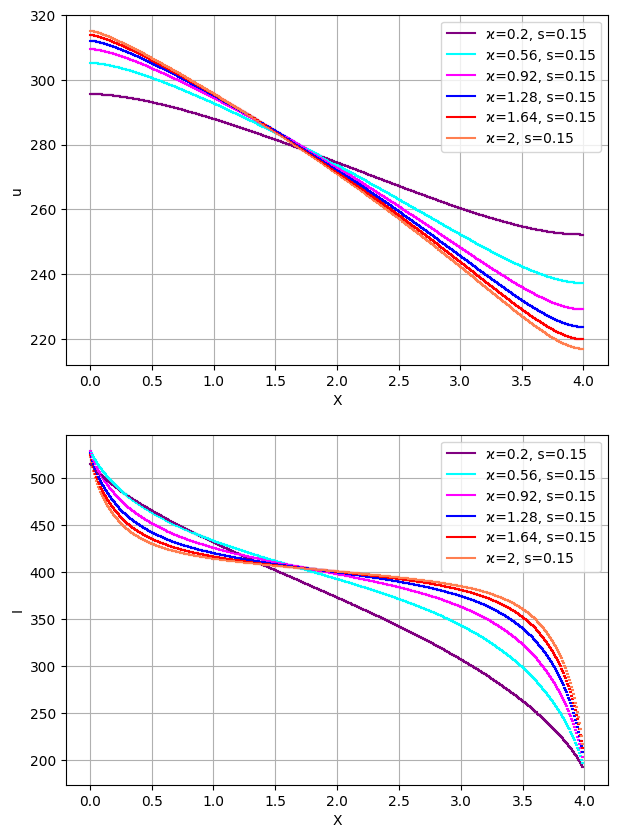

In [65]:
graph(4, u13, u14, u15, u16, u17, u18, I13, I14, I15, I16, I17, I18, 1)

In [66]:
u19, I19 = solver(4, 1000, 0.3, s_0, 0.1, 0.6, 650)
u20, I20 = solver(4, 1000, 0.3, s_0, 1.08, 0.6, 650)
u21, I21 = solver(4, 1000, 0.3, s_0, 2.06, 0.6, 650)
u22, I22 = solver(4, 1000, 0.3, s_0, 3.04, 0.6, 650)
u23, I23 = solver(4, 1000, 0.3, s_0, 4.02, 0.6, 650)
u24, I24 = solver(4, 1000, 0.3, s_0, 5, 0.6, 650)

524.403780877564
62.54237727248681
0.865940871161287
0.00016979493675505663
2.0561231821213798e-09
689.5625370844996
118.37407603692331
3.1879844438373808
0.00227380241856356
4.3308986624919625e-09
722.0958362157413
139.87524459728033
4.501866322128446
0.004458846425566728
3.520232909009486e-09
727.5177899951298
150.5319723508541
5.212560017436834
0.0058645071076748375
3.6622009380776414e-09
723.9151675859707
156.15543771208158
5.576924582294823
0.006589882844098115
1.0030109344418288e-08
716.8042291159081
159.02140527672714
5.736396098325373
0.006856031898236395
8.023000230135027e-09


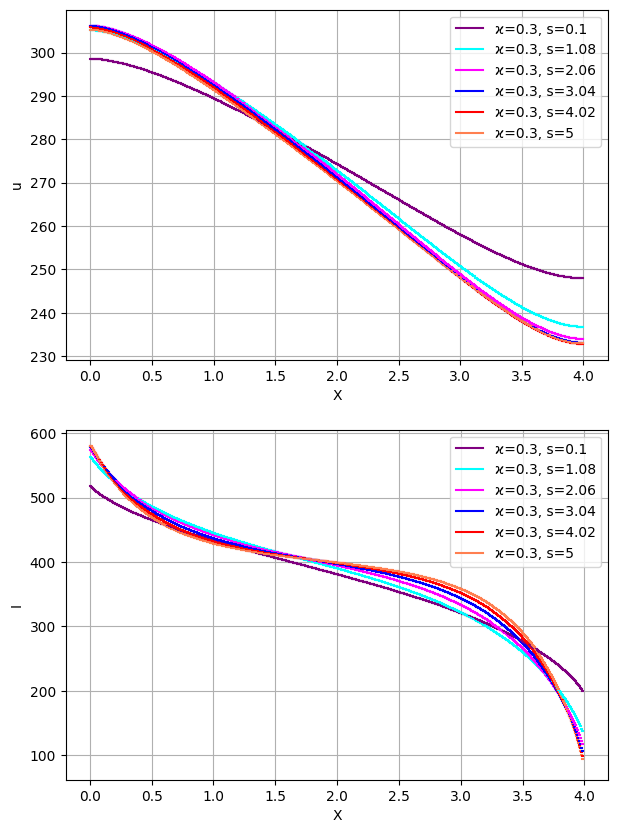

In [67]:
graph(4, u19, u20, u21, u22, u23, u24, I19, I20, I21, I22, I23, I24, 2)

In [34]:
u25, I25 = solver(1, 1000, 0.3, s_0, 10, 0.6, 800)
u26, I26 = solver(1, 1000, 0.3, s_0, 30, 0.6, 800)
u27, I27 = solver(1, 1000, 0.3, s_0, 50, 0.6, 800)
u28, I28 = solver(1, 1000, 0.3, s_0, 70, 0.6, 800)
u29, I29 = solver(1, 1000, 0.3, s_0, 80, 0.6, 800)
u30, I30 = solver(1, 1000, 0.3, s_0, 100, 0.6, 800)

380.4255743530758
24.297314924727676
0.09928421379601665
1.683935402188186e-06
5.316060962772679e-08
330.7140532383294
20.06209743052595
0.06821463152410971
7.91742264100845e-07
274.88256187438316
14.996307873367288
0.03826133829247025
2.8065592933193027e-07
219.95165996145434
10.59893971827989
0.019189594709362778
3.25201816063086e-08
193.8057773334577
8.774268896523555
0.013178101814787027
6.997878051263279e-08
147.72807295374278
6.009161556124276
0.006201032464368991
6.103673907777058e-08


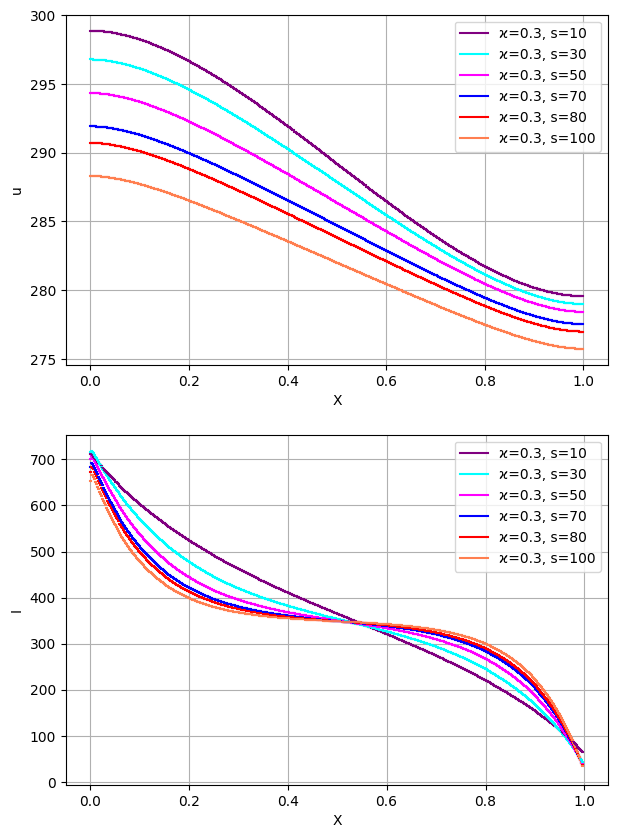

In [37]:
graph(1, u25, u26, u27, u28, u29, u30, I25, I26, I27, I28, I29, I30, 2)

In [42]:
u31, I31 = solver(1, 1300, 10, s_0, 0.25, 0.6, 800)
u32, I32 = solver(1, 1300, 30, s_0, 0.25, 0.6, 800)
u33, I33 = solver(1, 1300, 50, s_0, 0.25, 0.6, 800)
u34, I34 = solver(1, 1300, 70, s_0, 0.25, 0.6, 800)
u35, I35 = solver(1, 1300, 80, s_0, 0.25, 0.6, 800)
u36, I36 = solver(1, 1300, 100, s_0, 0.25, 0.6, 800)

910.6049711788987
186.28911550236793
6.286118679693856
0.006262265709781093
3.742023773398041e-08


IndexError: index 1000 is out of bounds for axis 0 with size 1000

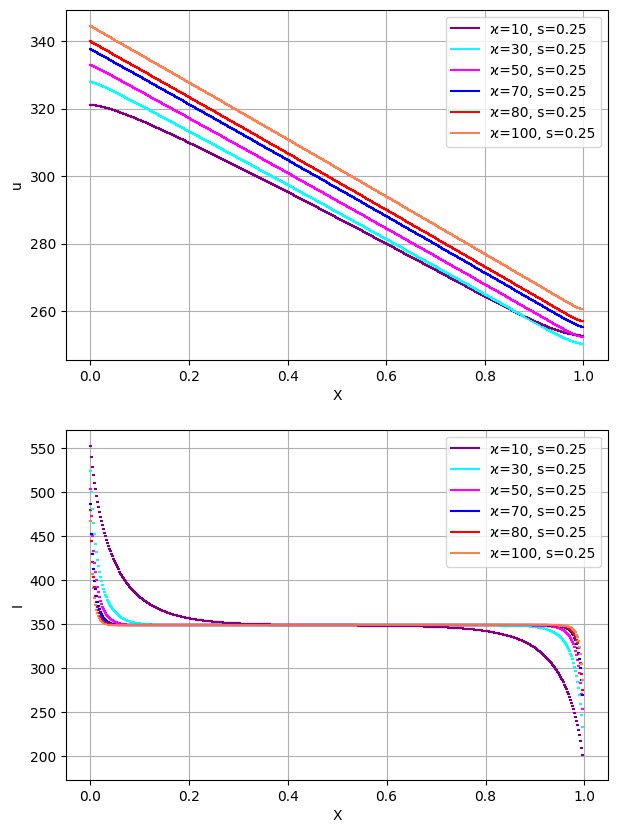

In [41]:
graph(1, u31, u32, u33, u34, u35, u36, I31, I32, I33, I34, I35, I36, 1)

In [45]:
u25, I25 = solver(1, 1000, 0.3, s_0, 0.25, 10, 800)
u26, I26 = solver(1, 1000, 0.3, s_0, 0.25, 30, 800)
u27, I27 = solver(1, 1000, 0.3, s_0, 0.25, 50, 800)
u28, I28 = solver(1, 1000, 0.3, s_0, 0.25, 70, 800)
u29, I29 = solver(1, 1000, 0.3, s_0, 0.25, 80, 800)
u30, I30 = solver(1, 1000, 0.3, s_0, 0.25, 100, 800)

333.26317308635265
17.26869154270954
0.048899706896811626
1.140791899556381e-06
6.888311479464469e-08
333.1946511556005
17.261006659240472
0.04885729443649192
2.5032598776774102e-06
1.9161113048480135e-07
333.18909694529293
17.260311309665187
0.048857029166728794
1.6186981138682789e-07
333.1875778279662
17.26010811786237
0.0488574713758792
4.514556275425675e-06
1.62279899822365e-06
7.89298410297464e-07
333.1872142452537
17.260072391682762
0.04885039502467934
1.4523508058581153e-06
7.420905761656937e-08
333.1867881138782
17.260012973025052
0.04884953176385832
4.746858531841567e-06
3.8415507002906713e-07


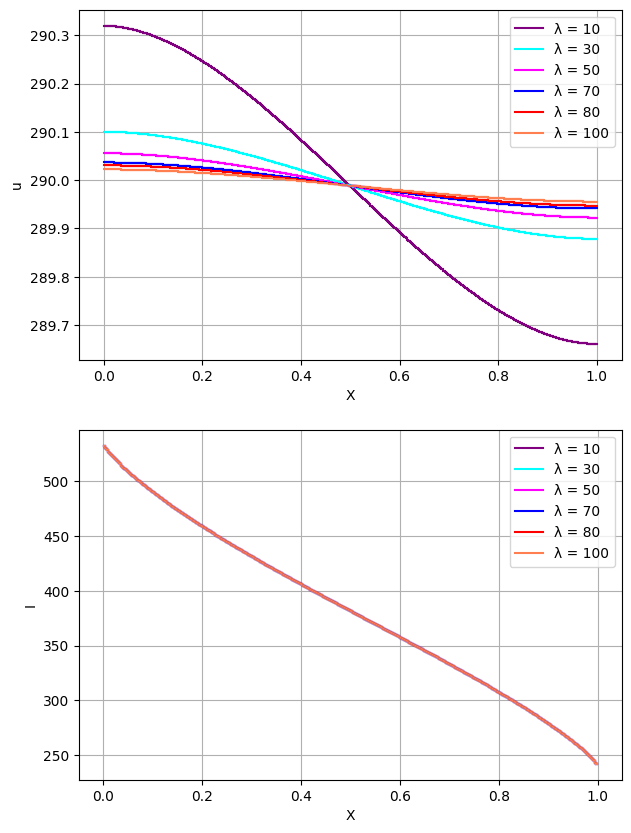

In [47]:
graph(1, u25, u26, u27, u28, u29, u30, I25, I26, I27, I28, I29, I30, 4)

In [48]:
u11, I11 = solver(1, 1000, 0.3, s_0, 0.25, 0, 800)
u12, I12 = solver(1, 1000, 0.3, s_0, 0.25, 0.1, 800)
u13, I13 = solver(1, 1000, 0.3, s_0, 0.25, 0.05, 800)
u14, I14 = solver(1, 1000, 0.3, s_0, 0.25, 0.01, 800)
u15, I15 = solver(1, 1000, 0.3, s_0, 0.25, 0.005, 800)
u16, I16 = solver(1, 1000, 0.3, s_0, 0.25, 0.001, 800)

716.9235733002773
140.56587124708076
53.38976882091589
11.17811209393149
0.4462512037814926
0.0006890612972427361
1.640676082387014e-09
456.57261796803004
36.4203337381589
0.25143589151217627
1.1765312532717706e-05
3.721381742012223e-09
518.2954573355564
48.90943045149652
0.5046491341111242
5.414963100964091e-05
1.803427067024751e-09
608.0082994272445
70.80985539168209
1.2935972991902789
0.0004712187341549487
9.536845369547072e-10
624.2691067055466
75.85129515642467
1.5717114999497026
0.000768231534426402
7.571285574891825e-10
639.4278151852816
81.49856846102541
1.9764644998916354
0.001470748398017179
9.56171068843609e-10


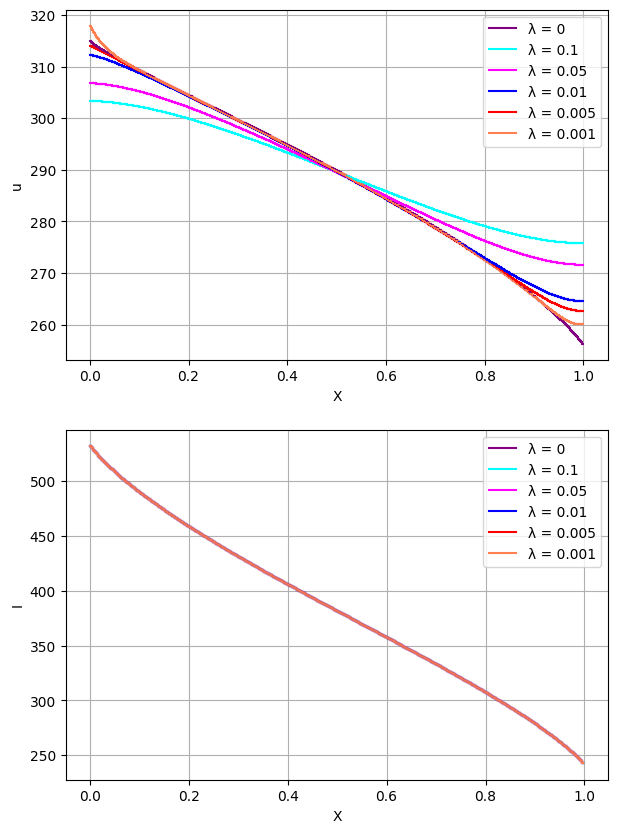

In [51]:
graph(1, u11, u12, u13, u14, u15, u16, I11, I12, I13, I14, I15, I16, 5)

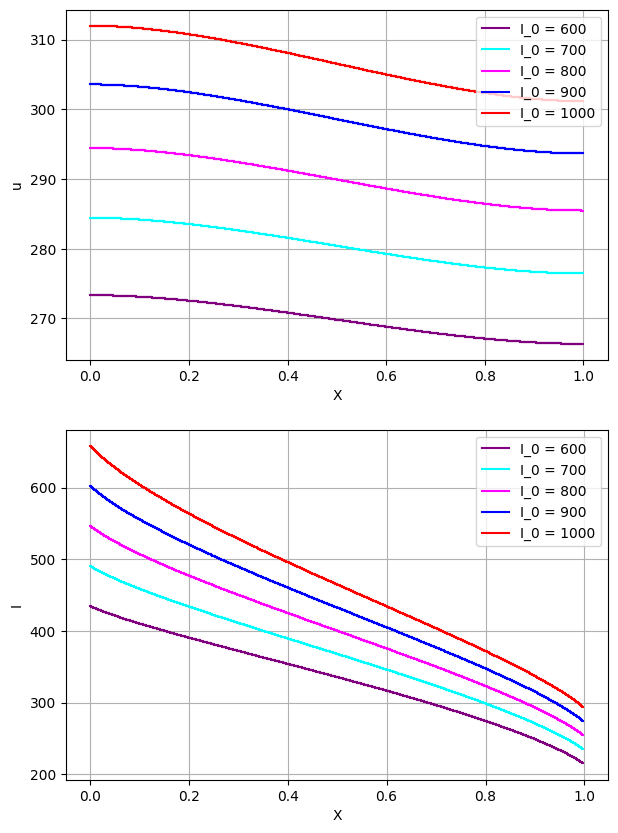

In [35]:
a = grid(L, n)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X')
axs[0].set_ylabel('u')

axs[1].set_xlabel('X')
axs[1].set_ylabel('I')
col = ['purple', 'cyan', 'fuchsia', 'blue', 'red']

for i in range(2):
    axs[i].plot([], [], color=col[0], label = 'I_0 = 600')
    axs[i].plot([], [], color=col[1], label = 'I_0 = 700')
    axs[i].plot([], [], color=col[2], label = 'I_0 = 800')
    axs[i].plot([], [], color=col[3], label = 'I_0 = 900')
    axs[i].plot([], [], color=col[4], label = 'I_0 = 1000')

for i in range(len(u1)):
    axs[0].plot([a[i], a[i+1]], [u11[i], u11[i]], color = col[0])
    axs[0].plot([a[i], a[i+1]], [u12[i], u12[i]], color = col[1])
    axs[0].plot([a[i], a[i+1]], [u13[i], u13[i]], color = col[2])
    axs[0].plot([a[i], a[i+1]], [u14[i], u14[i]], color = col[3])
    axs[0].plot([a[i], a[i+1]], [u15[i], u15[i]], color = col[4])

for i in range(1, len(u1)-2):
    axs[1].plot([a[i], a[i+1]], [I11[i], I11[i]], color = col[0])
    axs[1].plot([a[i], a[i+1]], [I12[i], I12[i]], color = col[1])
    axs[1].plot([a[i], a[i+1]], [I13[i], I13[i]], color = col[2])
    axs[1].plot([a[i], a[i+1]], [I14[i], I14[i]], color = col[3])
    axs[1].plot([a[i], a[i+1]], [I15[i], I15[i]], color = col[4])
axs[0].legend()
axs[1].legend()

plt.show()

In [40]:
u16, I16 = solver(4, 1000, 0.2, s_0, 0.15, 0.6, 650)
u17, I17 = solver(4, 1000, 0.25, s_0, 0.15, 0.6, 650)
u18, I18 = solver(4, 1000, 0.3, s_0, 0.15, 0.6, 650)
u19, I19 = solver(4, 1000, 0.35, s_0, 0.15, 0.6, 650)
u20, I20 = solver(4, 1000, 0.4, s_0, 0.15, 0.6, 650)

463.85831678319096
46.786611803239474
0.45367078518284576
4.298469877136158e-05
2.379936450419308e-09
507.1812882147793
57.39790659162401
0.7077062910966739
0.00010924559197219922
1.2087236539478659e-08
3.1575714355046924e-09
543.4651042020632
67.45826102248414
1.0084478628340856
0.00023006038556801456
1.9874256136916274e-09
574.4963002704997
77.00957697198861
1.351022193954703
0.00042593335635034504
1.0395404146286166e-08
1.5923418804752496e-09
601.4526976598336
86.09204365955563
1.730916108801943
0.0007181244772045366
2.9982410652441906e-09


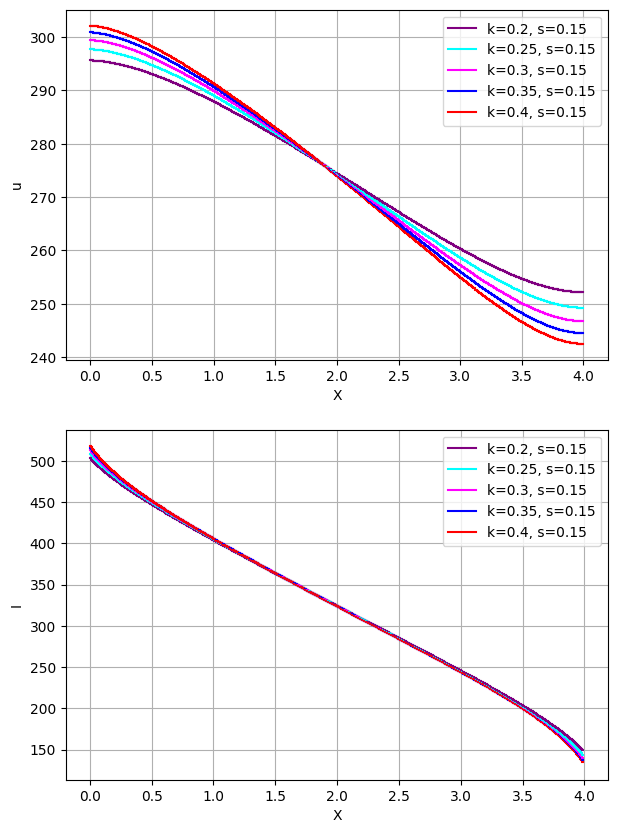

In [42]:
a = grid(4, n)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X')
axs[0].set_ylabel('u')

axs[1].set_xlabel('X')
axs[1].set_ylabel('I')
col = ['purple', 'cyan', 'fuchsia', 'blue', 'red']

for i in range(2):
    axs[i].plot([], [], color=col[0], label = 'k=0.2, s=0.15')
    axs[i].plot([], [], color=col[1], label = 'k=0.25, s=0.15')
    axs[i].plot([], [], color=col[2], label = 'k=0.3, s=0.15')
    axs[i].plot([], [], color=col[3], label = 'k=0.35, s=0.15')
    axs[i].plot([], [], color=col[4], label = 'k=0.4, s=0.15')

for i in range(len(u1)):
    axs[0].plot([a[i], a[i+1]], [u16[i], u16[i]], color = col[0])
    axs[0].plot([a[i], a[i+1]], [u17[i], u17[i]], color = col[1])
    axs[0].plot([a[i], a[i+1]], [u18[i], u18[i]], color = col[2])
    axs[0].plot([a[i], a[i+1]], [u19[i], u19[i]], color = col[3])
    axs[0].plot([a[i], a[i+1]], [u20[i], u20[i]], color = col[4])

for i in range(1, len(u1)-2):
    axs[1].plot([a[i], a[i+1]], [I16[i], I16[i]], color = col[0])
    axs[1].plot([a[i], a[i+1]], [I17[i], I17[i]], color = col[1])
    axs[1].plot([a[i], a[i+1]], [I18[i], I18[i]], color = col[2])
    axs[1].plot([a[i], a[i+1]], [I19[i], I19[i]], color = col[3])
    axs[1].plot([a[i], a[i+1]], [I20[i], I20[i]], color = col[4])
axs[0].legend()
axs[1].legend()

plt.show()

In [44]:
u21, I21 = solver(4, 1000, 0.3, s_0, 0.05, 0.6, 650)
u22, I22 = solver(4, 1000, 0.3, s_0, 0.15, 0.6, 650)
u23, I23 = solver(4, 1000, 0.3, s_0, 0.25, 0.6, 650)
u24, I24 = solver(4, 1000, 0.3, s_0, 0.35, 0.6, 650)
u25, I25 = solver(4, 1000, 0.3, s_0, 0.45, 0.6, 650)

502.4892172329353
57.20088510441005
0.7238995868167929
0.00011878761411048085
2.4586324844668838e-09
543.4651042020632
67.45826102248414
1.0084478628340856
0.00023006038556801456
1.9874256136916274e-09
575.0047677895677
76.20731092494147
1.2905273789747087
0.00037624151285992687
7.664501742870928e-09
599.9939133559506
83.76769499037697
1.5642461021801304
0.0005521182819139965
2.8902284766809557e-09
620.2115777271134
90.37350473435684
1.8266603905040637
0.0007521099508679332
4.872942273962799e-09


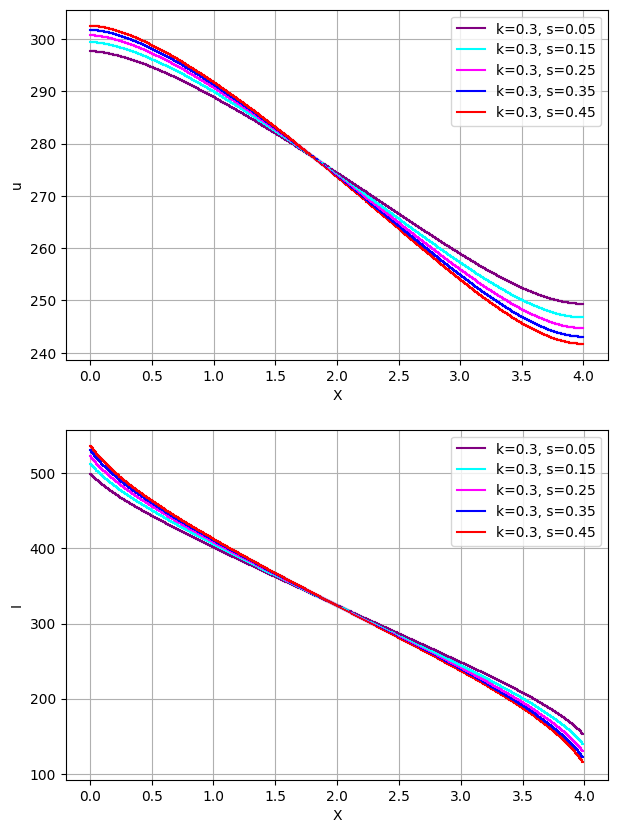

In [45]:
a = grid(4, n)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X')
axs[0].set_ylabel('u')

axs[1].set_xlabel('X')
axs[1].set_ylabel('I')
col = ['purple', 'cyan', 'fuchsia', 'blue', 'red']

for i in range(2):
    axs[i].plot([], [], color=col[0], label = 'k=0.3, s=0.05')
    axs[i].plot([], [], color=col[1], label = 'k=0.3, s=0.15')
    axs[i].plot([], [], color=col[2], label = 'k=0.3, s=0.25')
    axs[i].plot([], [], color=col[3], label = 'k=0.3, s=0.35')
    axs[i].plot([], [], color=col[4], label = 'k=0.3, s=0.45')

for i in range(len(u1)):
    axs[0].plot([a[i], a[i+1]], [u21[i], u21[i]], color = col[0])
    axs[0].plot([a[i], a[i+1]], [u22[i], u22[i]], color = col[1])
    axs[0].plot([a[i], a[i+1]], [u23[i], u23[i]], color = col[2])
    axs[0].plot([a[i], a[i+1]], [u24[i], u24[i]], color = col[3])
    axs[0].plot([a[i], a[i+1]], [u25[i], u25[i]], color = col[4])

for i in range(1, len(u1)-2):
    axs[1].plot([a[i], a[i+1]], [I21[i], I21[i]], color = col[0])
    axs[1].plot([a[i], a[i+1]], [I22[i], I22[i]], color = col[1])
    axs[1].plot([a[i], a[i+1]], [I23[i], I23[i]], color = col[2])
    axs[1].plot([a[i], a[i+1]], [I24[i], I24[i]], color = col[3])
    axs[1].plot([a[i], a[i+1]], [I25[i], I25[i]], color = col[4])
axs[0].legend()
axs[1].legend()

plt.show()

In [46]:
u26, I26 = solver(4, 1000, 0.3, s_0, 0.25, 0.6, 450)
u27, I27 = solver(4, 1000, 0.3, s_0, 0.25, 0.6, 500)
u28, I28 = solver(4, 1000, 0.3, s_0, 0.25, 0.6, 550)
u29, I29 = solver(4, 1000, 0.3, s_0, 0.25, 0.6, 600)
u30, I30 = solver(4, 1000, 0.3, s_0, 0.25, 0.6, 650)

869.3958021627037
198.53646706010755
9.481372218142756
0.02096640147001491
9.932635449965113e-08
4.950889727266257e-09
753.5356507098205
153.02384846311088
5.678273938761069
0.007580740223440918
1.1005478011990645e-08
2.3500356161606484e-09
658.9905304898442
118.25981237173494
3.3996888003498764
0.0027289103765855637
3.785110648362773e-09
595.9921878447517
92.55519494931933
2.0487780489611676
0.0009866528046469421
6.376050463893548e-09
575.0047677895677
76.20731092494147
1.2905273789747087
0.00037624151285992687
7.664501742870928e-09


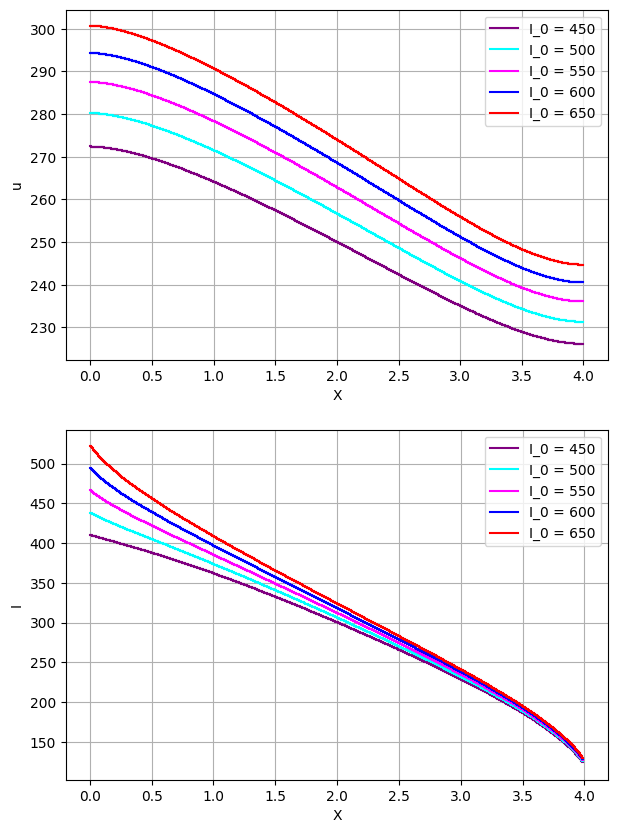

In [47]:
a = grid(4, n)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X')
axs[0].set_ylabel('u')

axs[1].set_xlabel('X')
axs[1].set_ylabel('I')
col = ['purple', 'cyan', 'fuchsia', 'blue', 'red']

for i in range(2):
    axs[i].plot([], [], color=col[0], label = 'I_0 = 450')
    axs[i].plot([], [], color=col[1], label = 'I_0 = 500')
    axs[i].plot([], [], color=col[2], label = 'I_0 = 550')
    axs[i].plot([], [], color=col[3], label = 'I_0 = 600')
    axs[i].plot([], [], color=col[4], label = 'I_0 = 650')

for i in range(len(u1)):
    axs[0].plot([a[i], a[i+1]], [u26[i], u26[i]], color = col[0])
    axs[0].plot([a[i], a[i+1]], [u27[i], u27[i]], color = col[1])
    axs[0].plot([a[i], a[i+1]], [u28[i], u28[i]], color = col[2])
    axs[0].plot([a[i], a[i+1]], [u29[i], u29[i]], color = col[3])
    axs[0].plot([a[i], a[i+1]], [u30[i], u30[i]], color = col[4])

for i in range(1, len(u1)-2):
    axs[1].plot([a[i], a[i+1]], [I26[i], I26[i]], color = col[0])
    axs[1].plot([a[i], a[i+1]], [I27[i], I27[i]], color = col[1])
    axs[1].plot([a[i], a[i+1]], [I28[i], I28[i]], color = col[2])
    axs[1].plot([a[i], a[i+1]], [I29[i], I29[i]], color = col[3])
    axs[1].plot([a[i], a[i+1]], [I30[i], I30[i]], color = col[4])
axs[0].legend()
axs[1].legend()

plt.show()

In [30]:
x_0 = 0
u100, I100 = solver(1, 1000, 0.3, s_0, 0, 0.6, 800)
u101, I101 = solver(1, 1000, 0.3, s_0, 0.01, 0.6, 800)
u102, I102 = solver(1, 1000, 0.3, s_0, 0.001, 0.6, 800)

KeyboardInterrupt: 

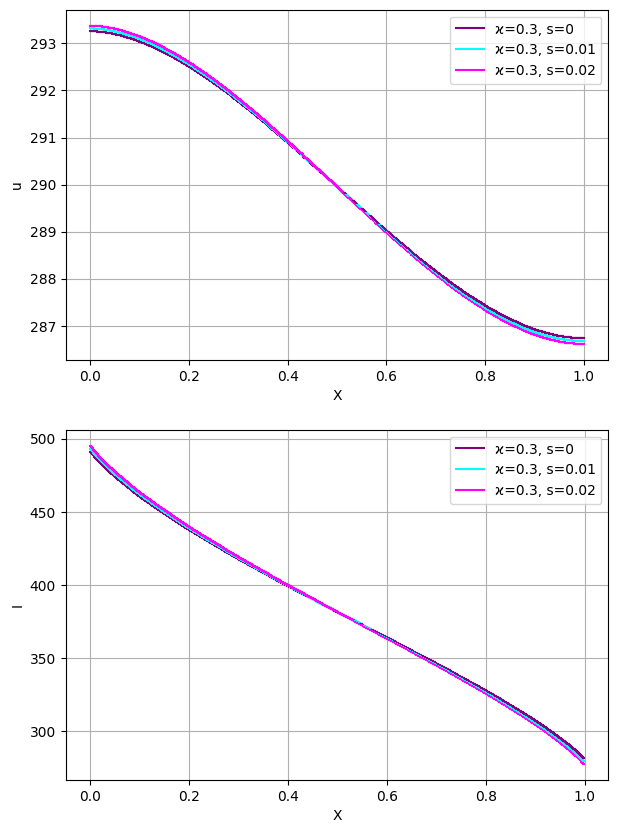

In [27]:
a = grid(1, n)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X')
axs[0].set_ylabel('u')

axs[1].set_xlabel('X')
axs[1].set_ylabel('I')
col = ['purple', 'cyan', 'fuchsia', 'blue', 'red']

for i in range(2):
    axs[i].plot([], [], color=col[0], label = '\u03F0=0.3, s=0')
    axs[i].plot([], [], color=col[1], label = '\u03F0=0.3, s=0.01')
    axs[i].plot([], [], color=col[2], label = '\u03F0=0.3, s=0.02')

for i in range(len(u1)):
    axs[0].plot([a[i], a[i+1]], [u100[i], u100[i]], color = col[0])
    axs[0].plot([a[i], a[i+1]], [u101[i], u101[i]], color = col[1])
    axs[0].plot([a[i], a[i+1]], [u102[i], u102[i]], color = col[2])

for i in range(1, len(u1)-2):
    axs[1].plot([a[i], a[i+1]], [I100[i], I100[i]], color = col[0])
    axs[1].plot([a[i], a[i+1]], [I101[i], I101[i]], color = col[1])
    axs[1].plot([a[i], a[i+1]], [I102[i], I102[i]], color = col[2])

axs[0].legend()
axs[1].legend()

plt.show()

In [28]:
u103, I103 = solver(1, 1000, 0.001, s_0, 0.15, 0.6, 800)
u104, I104 = solver(1, 1000, 0.01, s_0, 0.15, 0.6, 800)
u105, I105 = solver(1, 1000, 0.1, s_0, 0.15, 0.6, 800)

331.85374108002566
17.127857619192913
0.04810569377681938
2.8501996235321563e-06
2.887452251048704e-07
331.90727593902335
17.13330632553202
0.04814341707499951
6.383013091136433e-07
333.3994114318954
17.29125974524654
0.04903940552904346
3.079499833755546e-07


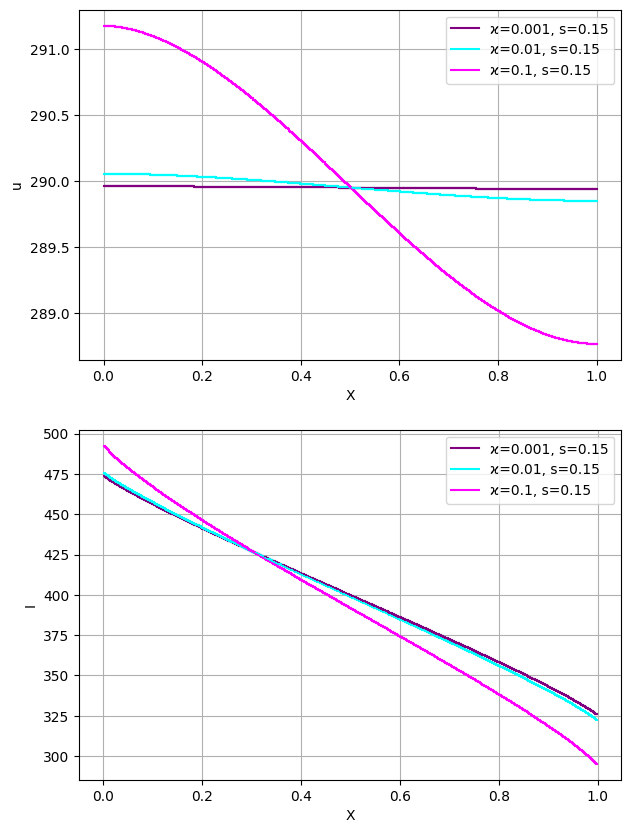

In [29]:
a = grid(1, n)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X')
axs[0].set_ylabel('u')

axs[1].set_xlabel('X')
axs[1].set_ylabel('I')
col = ['purple', 'cyan', 'fuchsia', 'blue', 'red']

for i in range(2):
    axs[i].plot([], [], color=col[0], label = '\u03F0=0.001, s=0.15')
    axs[i].plot([], [], color=col[1], label = '\u03F0=0.01, s=0.15')
    axs[i].plot([], [], color=col[2], label = '\u03F0=0.1, s=0.15')

for i in range(len(u1)):
    axs[0].plot([a[i], a[i+1]], [u103[i], u103[i]], color = col[0])
    axs[0].plot([a[i], a[i+1]], [u104[i], u104[i]], color = col[1])
    axs[0].plot([a[i], a[i+1]], [u105[i], u105[i]], color = col[2])

for i in range(1, len(u1)-2):
    axs[1].plot([a[i], a[i+1]], [I103[i], I103[i]], color = col[0])
    axs[1].plot([a[i], a[i+1]], [I104[i], I104[i]], color = col[1])
    axs[1].plot([a[i], a[i+1]], [I105[i], I105[i]], color = col[2])

axs[0].legend()
axs[1].legend()

plt.show()

In [65]:
u37, I37 = solver(1, 1000, 0.3, s_0, 0.15, 0.6, 0.001)
u38, I38 = solver(1, 1000, 0.3, s_0, 0.15, 0.6, 800)

2213.591179359837
1660.1890209375294
1245.1314242785709
933.8240560262002
700.309942749058
525.0947627610389
393.4948699970941
294.3497623169294
218.94611788505463
159.99527026225525
110.64838968990595
64.85709964856865
24.14359973098063
3.124265822473935
0.047597410862109564
0.00021300825597037051
0.00031882291478032524
0.0003294808472574279
0.00031416418697353146
0.00029931240777438586
0.00031982363565562834
0.00033951574479938995
0.0003115993243938381
0.0002841677482455354
0.00032308057561559295
0.000362259316426718
0.00030597632001421653
0.00025167076744559005
0.0003295103658951291
0.0004071459169410137
0.00029336018139845637
0.00017991789831985346
0.000345809634936822
0.0005236644512766357
0.00026248068072935423
2.2832351413199136e-05
3.302473608162478e-05
5.210951696795857e-05
7.215906063133285e-05
0.00011426797995161784
0.00015723897139235084
0.00035064818471690064
0.00056558937015907
0.00024719109237516043
0.0001518758448427673
0.00020930924304197156
0.00034111297434476554
0.00

KeyboardInterrupt: 

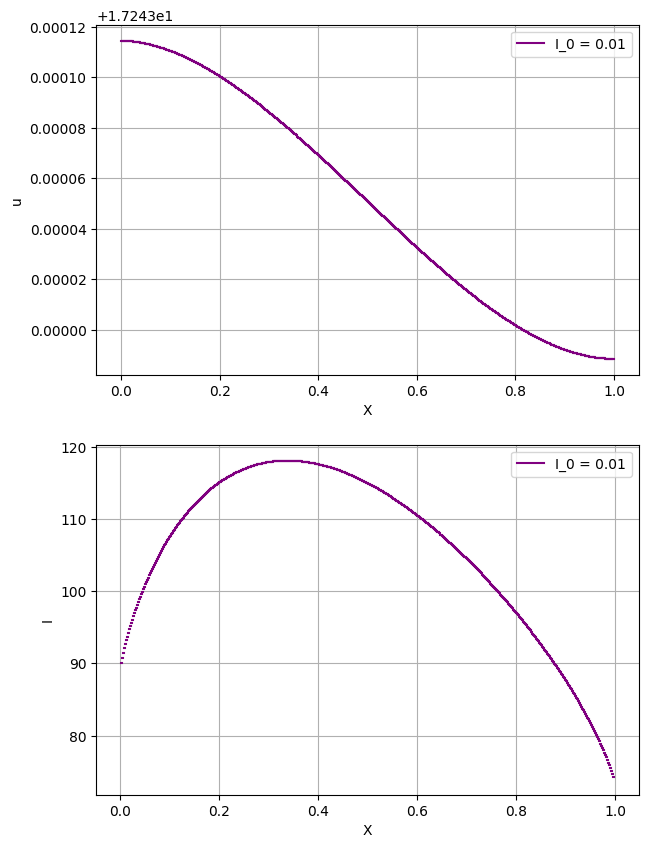

In [64]:
a = grid(1, n)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X')
axs[0].set_ylabel('u')

axs[1].set_xlabel('X')
axs[1].set_ylabel('I')
col = ['purple', 'cyan', 'fuchsia', 'blue', 'red']

for i in range(2):
    axs[i].plot([], [], color=col[0], label = 'I_0 = 0.001')

for i in range(len(u1)):
    axs[0].plot([a[i], a[i+1]], [u37[i], u37[i]], color = col[0])

for i in range(1, len(u1)-2):
    axs[1].plot([a[i], a[i+1]], [I37[i], I37[i]], color = col[0])

axs[0].legend()
axs[1].legend()

plt.show()

In [25]:
u39, I39 = solver(1, 1000, 0.15, s_0, 0.25, 0.6, 800)
u40, I40 = solver(1, 1000, 0.3, s_0, 0.25, 0.6, 800)
u41, I41 = solver(1, 1000, 0.15, s_0, 0.25, 1, 800)
u42, I42 = solver(1, 1000, 0.3, s_0, 0.25, 1, 800)

336.0416414927213
17.582872356937727
0.05073403840183365
4.737179771532308e-07
347.7414661371
18.955420255490843
0.05920457970848572
6.136696713893958e-07
333.8661119114852
17.34185816946595
0.04932810358539366
4.7536559041470806e-07
339.3583814234013
17.95680105914547
0.05294817856829275
5.234014691230588e-07


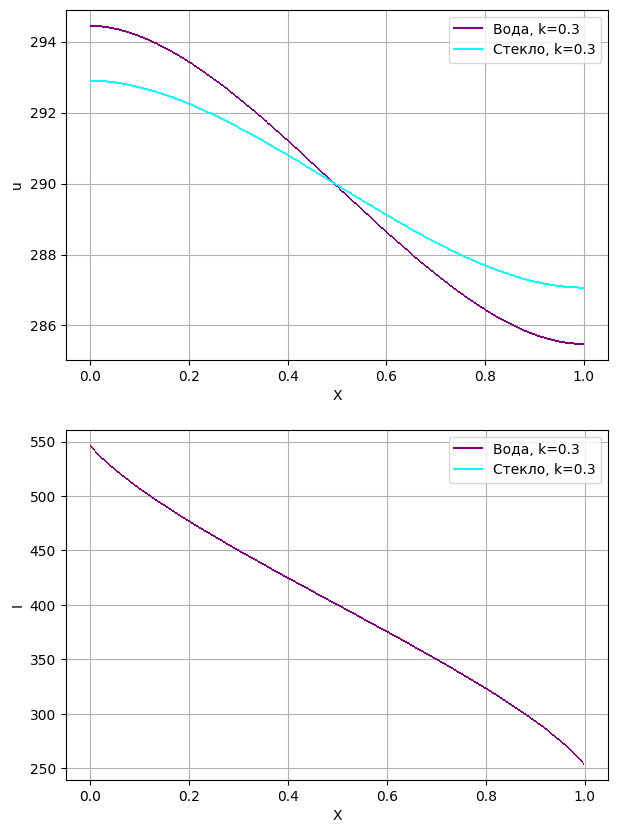

In [28]:
a = grid(1, n)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X')
axs[0].set_ylabel('u')

axs[1].set_xlabel('X')
axs[1].set_ylabel('I')
col = ['purple', 'cyan', 'fuchsia', 'blue', 'red']

for i in range(2):
    #axs[i].plot([], [], color=col[0], label = 'Вода, k=0.15')
    axs[i].plot([], [], color=col[0], label = 'Вода, k=0.3')
    #axs[i].plot([], [], color=col[1], label = 'Стекло, k=0.15')
    axs[i].plot([], [], color=col[1], label = 'Стекло, k=0.3')

for i in range(len(u1)):
    #axs[0].plot([a[i], a[i+1]], [u39[i], u39[i]], color = col[0])
    axs[0].plot([a[i], a[i+1]], [u40[i], u40[i]], color = col[0], ls = 'dashed')
    #axs[0].plot([a[i], a[i+1]], [u41[i], u41[i]], color = col[1])
    axs[0].plot([a[i], a[i+1]], [u42[i], u42[i]], color = col[1], ls = 'dashed')

for i in range(1, len(u1)-2):
    #axs[1].plot([a[i], a[i+1]], [I39[i], I39[i]], color = col[0])
    axs[1].plot([a[i], a[i+1]], [I40[i], I40[i]], color = col[0], ls = 'dashed')
    #axs[1].plot([a[i], a[i+1]], [I41[i], I41[i]], color = col[1])
    #axs[1].plot([a[i], a[i+1]], [I42[i], I42[i]], color = col[1], ls = 'dashed')

axs[0].legend()
axs[1].legend()

plt.show()

In [29]:
u42, I42 = solver(1, 1000, 0.3, s_0, 0.25, 0.12, 800)
u43, I43 = solver(1, 1000, 0.3, s_0, 0.25, 0.6, 800)
u44, I44 = solver(1, 1000, 0.3, s_0, 0.25, 1, 800)
u45, I45 = solver(1, 1000, 0.3, s_0, 0.25, 8, 800)

440.1404441321813
33.367888971864446
0.205455565432712
7.6210074174537205e-06
1.42029402199622e-09
347.7414661371
18.955420255490843
0.05920457970848572
6.136696713893958e-07
339.3583814234013
17.95680105914547
0.05294817856829275
5.234014691230588e-07
333.30604065048107
17.273487308041023
0.04892885862307539
4.97340716615563e-07


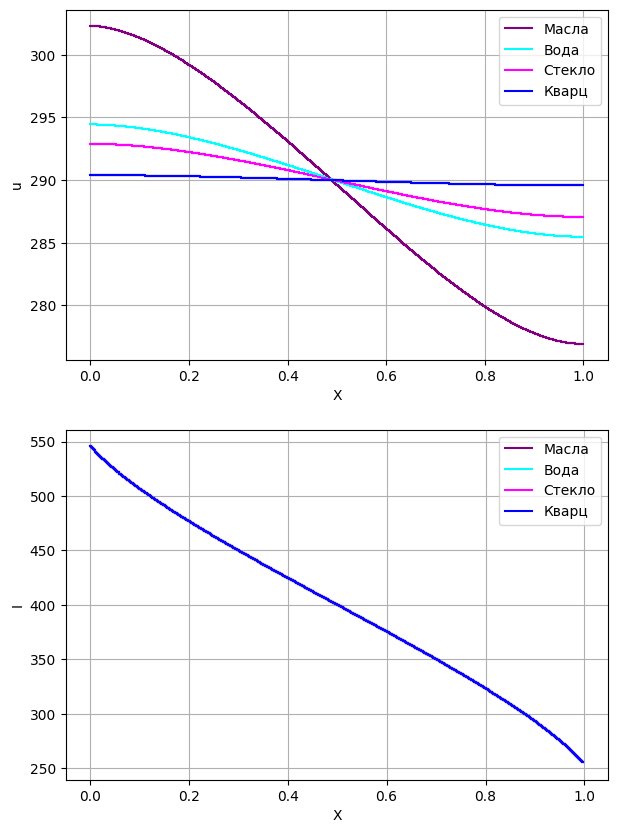

In [30]:
a = grid(1, n)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X')
axs[0].set_ylabel('u')

axs[1].set_xlabel('X')
axs[1].set_ylabel('I')
col = ['purple', 'cyan', 'fuchsia', 'blue', 'red']

for i in range(2):
    axs[i].plot([], [], color=col[0], label = 'Масла')
    axs[i].plot([], [], color=col[1], label = 'Вода')
    axs[i].plot([], [], color=col[2], label = 'Стекло')
    axs[i].plot([], [], color=col[3], label = 'Кварц')

for i in range(len(u1)):
    axs[0].plot([a[i], a[i+1]], [u42[i], u42[i]], color = col[0])
    axs[0].plot([a[i], a[i+1]], [u43[i], u43[i]], color = col[1])
    axs[0].plot([a[i], a[i+1]], [u44[i], u44[i]], color = col[2])
    axs[0].plot([a[i], a[i+1]], [u45[i], u45[i]], color = col[3])

for i in range(1, len(u1)-2):
    axs[1].plot([a[i], a[i+1]], [I42[i], I42[i]], color = col[0])
    axs[1].plot([a[i], a[i+1]], [I43[i], I43[i]], color = col[1])
    axs[1].plot([a[i], a[i+1]], [I44[i], I44[i]], color = col[2])
    axs[1].plot([a[i], a[i+1]], [I45[i], I45[i]], color = col[3])

axs[0].legend()
axs[1].legend()

plt.show()

In [35]:
u46, I46 = solver(1, 1000, 0.3, s_0, 0.25, 0, 800)
u47, I47 = solver(1, 1000, 0.3, s_0, 0.25, 0.1, 800)
u48, I48 = solver(1, 1000, 0.3, s_0, 0.25, 0.01, 800)
u49, I49 = solver(1, 1000, 0.3, s_0, 0.25, 0.001, 800)

716.9235733002773
140.56587124708076
53.38976882091589
11.17811209393149
0.4462512037814926
0.0006890612972427361
1.640676082387014e-09
456.57261796803004
36.4203337381589
0.25143589151217627
1.1765312532717706e-05
3.721381742012223e-09
608.0082994272445
70.80985539168209
1.2935972991902789
0.0004712187341549487
9.536845369547072e-10
639.4278151852816
81.49856846102541
1.9764644998916354
0.001470748398017179
9.56171068843609e-10


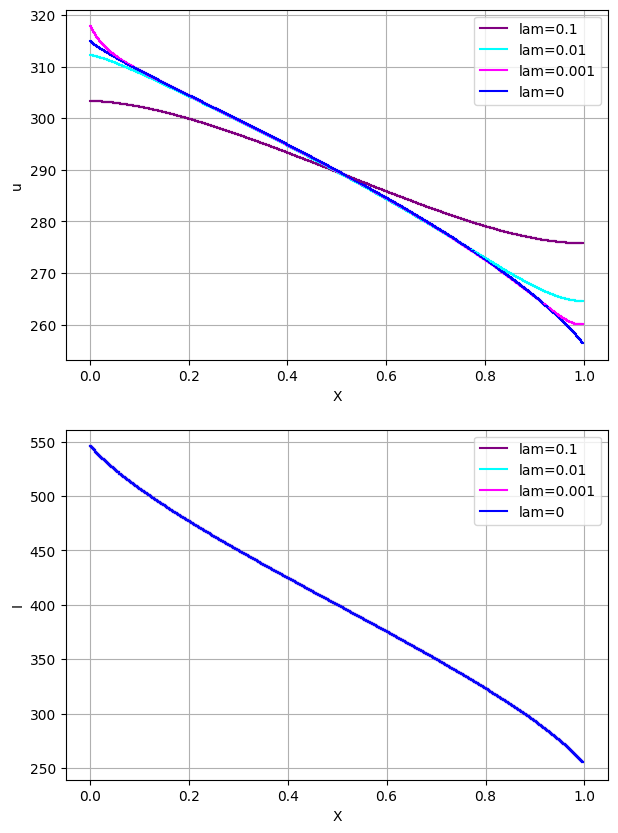

In [36]:
a = grid(1, n)

fig, axs = plt.subplots(2, 1, figsize = (7, 10))
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('X')
axs[0].set_ylabel('u')

axs[1].set_xlabel('X')
axs[1].set_ylabel('I')
col = ['purple', 'cyan', 'fuchsia', 'blue', 'red']

for i in range(2):
    axs[i].plot([], [], color=col[0], label = 'lam=0.1')
    axs[i].plot([], [], color=col[1], label = 'lam=0.01')
    axs[i].plot([], [], color=col[2], label = 'lam=0.001')
    axs[i].plot([], [], color=col[3], label = 'lam=0')

for i in range(1, len(u1)-1):
    axs[0].plot([a[i], a[i+1]], [u47[i], u47[i]], color = col[0])
    axs[0].plot([a[i], a[i+1]], [u48[i], u48[i]], color = col[1])
    axs[0].plot([a[i], a[i+1]], [u49[i], u49[i]], color = col[2])
    axs[0].plot([a[i], a[i+1]], [u46[i], u46[i]], color = col[3])

for i in range(1, len(u1)-2):
    axs[1].plot([a[i], a[i+1]], [I47[i], I47[i]], color = col[0])
    axs[1].plot([a[i], a[i+1]], [I48[i], I48[i]], color = col[1])
    axs[1].plot([a[i], a[i+1]], [I49[i], I49[i]], color = col[2])
    axs[1].plot([a[i], a[i+1]], [I46[i], I46[i]], color = col[3])

axs[0].legend()
axs[1].legend()

plt.show()